Name: Marcos David Madrigal Albores

Student #: 1004731347

In [ ]:
%%shell
jupyter nbconvert --to html /content/Lab_2_1004731347_MDMA.ipynb

[NbConvertApp] Converting notebook /content/Lab_2_1004731347_MDMA.ipynb to html
[NbConvertApp] Writing 958696 bytes to /content/Lab_2_1004731347_MDMA.html


# Lab 2: Cats vs Dogs

**Deadline**: Feb 01, 5:00pm

**Late Penalty**: There is a penalty-free grace period of one hour past the deadline. Any work that is submitted between 1 hour and 24 hours past the deadline will receive a 20% grade deduction. No other late work is accepted. Quercus submission time will be used, not your local computer time. You can submit your labs as many times as you want before the deadline, so please submit often and early.

**Marking TA**: Tinglin (Francis) Duan

This lab is partially based on an assignment developed by Prof. Jonathan Rose and Harris Chan.

In this lab, you will train a convolutional neural network to classify an image 
into one of two classes: "cat" or "dog". The code for the neural networks 
you train will be written for you, and you are not (yet!) expected
to understand all provided code. However, by the end of the lab,
you should be able to:

1. Understand at a high level the training loop for a machine learning model.
2. Understand the distinction between training, validation, and test data.
3. The concepts of overfitting and underfitting.
4. Investigate how different hyperparameters, such as learning rate and batch size, affect the success of training.
5. Compare an ANN (aka Multi-Layer Perceptron) with a CNN.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up
from parts 1-5. You can produce a PDF of your Google Colab file by
going to **File > Print** and then save as PDF. The Colab instructions
has more information.

**Do not submit any other files produced by your code.**

Include a link to your colab file in your submission.

Please use Google Colab to complete this assignment. If you want to use Jupyter Notebook, please complete the assignment and upload your Jupyter Notebook file to Google Colab for submission. 

With Colab, you can export a PDF file using the menu option
`File -> Print` and save as PDF file. **Adjust the scaling to ensure that the text is not cutoff at the margins.**

## Colab Link

Include a link to your colab file here

Colab Link: https://colab.research.google.com/drive/13-7DCeDmNHcaNIB3yMW8PYk0_uCv_1by?usp=sharing


In [ ]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms




## Part 0. Helper Functions

We will be making use of the following helper functions. You will be asked to look
at and possibly modify some of these, but you are not expected to understand all of them.

You should look at the function names and read the docstrings. If you are curious, come back and explore the code *after* making some progress on the lab.

In [ ]:
###############################################################################
# Data Loading

def get_relevant_indices(dataset, classes, target_classes):
    """ Return the indices for datapoints in the dataset that belongs to the
    desired target classes, a subset of all possible classes.

    Args:
        dataset: Dataset object
        classes: A list of strings denoting the name of each class
        target_classes: A list of strings denoting the name of desired classes
                        Should be a subset of the 'classes'
    Returns:
        indices: list of indices that have labels corresponding to one of the
                 target classes
    """
    indices = []
    for i in range(len(dataset)):
        # Check if the label is in the target classes
        label_index = dataset[i][1] # ex: 3
        label_class = classes[label_index] # ex: 'cat'
        if label_class in target_classes:
            indices.append(i)
    return indices

def get_data_loader(target_classes, batch_size):
    """ Loads images of cats and dogs, splits the data into training, validation
    and testing datasets. Returns data loaders for the three preprocessed datasets.

    Args:
        target_classes: A list of strings denoting the name of the desired
                        classes. Should be a subset of the argument 'classes'
        batch_size: A int representing the number of samples per batch
    
    Returns:
        train_loader: iterable training dataset organized according to batch size
        val_loader: iterable validation dataset organized according to batch size
        test_loader: iterable testing dataset organized according to batch size
        classes: A list of strings denoting the name of each class
    """

    classes = ('plane', 'car', 'bird', 'cat',
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    ########################################################################
    # The output of torchvision datasets are PILImage images of range [0, 1].
    # We transform them to Tensors of normalized range [-1, 1].
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    # Load CIFAR10 training data
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_indices = get_relevant_indices(trainset, classes, target_classes)
    
    # Split into train and validation
    np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling
    np.random.shuffle(relevant_indices)
    split = int(len(relevant_indices) * 0.8) #split at 80%
    
    # split into training and validation indices
    relevant_train_indices, relevant_val_indices = relevant_indices[:split], relevant_indices[split:]  
    train_sampler = SubsetRandomSampler(relevant_train_indices)
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               num_workers=1, sampler=train_sampler)
    val_sampler = SubsetRandomSampler(relevant_val_indices)
    val_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              num_workers=1, sampler=val_sampler)
    # Load CIFAR10 testing data
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_test_indices = get_relevant_indices(testset, classes, target_classes)
    test_sampler = SubsetRandomSampler(relevant_test_indices)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             num_workers=1, sampler=test_sampler)
    return train_loader, val_loader, test_loader, classes

###############################################################################
# Training
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

def normalize_label(labels):
    """
    Given a tensor containing 2 possible values, normalize this to 0/1

    Args:
        labels: a 1D tensor containing two possible scalar values
    Returns:
        A tensor normalize to 0/1 value
    """
    max_val = torch.max(labels)
    min_val = torch.min(labels)
    norm_labels = (labels - min_val)/(max_val - min_val)
    return norm_labels

def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        labels = normalize_label(labels)  # Convert labels to 0/1
        outputs = net(inputs)
        loss = criterion(outputs, labels.float())
        corr = (outputs > 0.0).squeeze().long() != labels
        total_err += int(corr.sum())
        total_loss += loss.item()
        total_epoch += len(labels)
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss

###############################################################################
# Training Curve
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

## Part 1. Visualizing the Data [7 pt]

We will make use of some of the CIFAR-10 data set, which consists of 
colour images of size 32x32 pixels belonging to 10 categories. You can
find out more about the dataset at https://www.cs.toronto.edu/~kriz/cifar.html

For this assignment, we will only be using the cat and dog categories. 
We have included code that automatically downloads the dataset the 
first time that the main script is run.

In [ ]:
# This will download the CIFAR-10 dataset to a folder called "data"
# the first time you run this code.
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"], 
    batch_size=1) # One image per batch

Files already downloaded and verified
Files already downloaded and verified


### Part (a) -- 1 pt

Visualize some of the data by running the code below.
Include the visualization in your writeup.

(You don't need to submit anything else.)

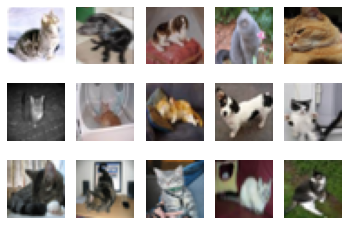

In [ ]:
import matplotlib.pyplot as plt

k = 0
for images, labels in train_loader:
    # since batch_size = 1, there is only 1 image in `images`
    image = images[0]
    # place the colour channel at the end, instead of at the beginning
    img = np.transpose(image, [1,2,0])
    # normalize pixel intensity values to [0, 1]
    img = img / 2 + 0.5
    plt.subplot(3, 5, k+1)
    plt.axis('off')
    plt.imshow(img)

    k += 1
    if k > 14:
        break

### Part (b) -- 3 pt

How many training examples do we have for the combined `cat` and `dog` classes? 
What about validation examples? 
What about test examples?

In [ ]:
print(len(train_loader))
print(len(val_loader))
print(len(test_loader))
#So the Training set has 8000 items (split 80 - 20 with the Vaidation set) 
#, the Validation set has 2000 items and the Testing set has 2000 items 

8000
2000
2000


### Part (c) -- 3pt

Why do we need a validation set when training our model? What happens if we judge the 
performance of our models using the training set loss/error instead of the validation
set loss/error?

In [ ]:
#We need a validation set to test our model on "new" data that wasnt part
#of the training set. Judging a models performance based on how well it performs 
#against the same dataset it used to get trained on gives the model the possibility
# to overfit to the training data and memorize this set 
#(which overall results in worse performance when pitted against unseem cases)

## Part 2. Training [15 pt]

We define two neural networks, a `LargeNet` and `SmallNet`.
We'll be training the networks in this section.

You won't understand fully what these networks are doing until
the next few classes, and that's okay. For this assignment, please
focus on learning how to train networks, and how hyperparameters affect
training.

In [ ]:
class LargeNet(nn.Module):
    def __init__(self):
        super(LargeNet, self).__init__()
        self.name = "large"
        self.conv1 = nn.Conv2d(3, 5, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 5)
        self.fc1 = nn.Linear(10 * 5 * 5, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [ ]:
class SmallNet(nn.Module):
    def __init__(self):
        super(SmallNet, self).__init__()
        self.name = "small"
        self.conv = nn.Conv2d(3, 5, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(5 * 7 * 7, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv(x)))
        x = self.pool(x)
        x = x.view(-1, 5 * 7 * 7)
        x = self.fc(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [ ]:
small_net = SmallNet()
large_net = LargeNet()

### Part (a) -- 2pt

The methods `small_net.parameters()` and `large_net.parameters()`
produces an iterator of all the trainable parameters of the network.
These parameters are torch tensors containing many scalar values. 

We haven't learned how how the parameters in these high-dimensional
tensors will be used, but we should be able to count the number
of parameters. Measuring the number of parameters in a network is
one way of measuring the "size" of a network.

What is the total number of parameters in `small_net` and in
`large_net`? (Hint: how many numbers are in each tensor?)

In [1]:
print('Small Net \n')
for param in small_net.parameters():
    print(param.shape)
#4 different tensors, the first one with 5*3*3*3 = 135 parameters, the second one with 5 parameters, 
#the third one with 1*245 parameters and the last one with 1 parameter, for a total of 396 parameters across all 4 tensors
print('Large Net \n')
for param in large_net.parameters():
    print(param.shape)
#8 different tensors: 5*5*5*3 + 5 + 5*5*5*10 + 10 + 32*250 + 32 + 1*32 + 1 = 9705 parameters across 8 tensors

Small Net 



NameError: ignored

### The function train_net

The function `train_net` below takes an untrained neural network (like `small_net` and `large_net`) and
several other parameters. You should be able to understand how this function works.
The figure below shows the high level training loop for a machine learning model:

![alt text](https://github.com/UTNeural/Lab2/blob/master/Diagram.png?raw=true)

In [ ]:
def train_net(net, batch_size=64, learning_rate=0.01, num_epochs=30):
    ########################################################################
    # Train a classifier on cats vs dogs
    target_classes = ["cat", "dog"]
    ########################################################################
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)
    ########################################################################
    # Obtain the PyTorch data loader objects to load batches of the datasets
    train_loader, val_loader, test_loader, classes = get_data_loader(
            target_classes, batch_size)
    ########################################################################
    # Define the Loss function and optimizer
    # The loss function will be Binary Cross Entropy (BCE). In this case we
    # will use the BCEWithLogitsLoss which takes unnormalized output from
    # the neural network and scalar label.
    # Optimizer will be SGD with Momentum.
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    ########################################################################
    # Set up some numpy arrays to store the training/test loss/erruracy
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    start_time = time.time()
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        for i, data in enumerate(train_loader, 0):
            # Get the inputs
            inputs, labels = data
            labels = normalize_label(labels) # Convert labels to 0/1
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass, backward pass, and optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()
            # Calculate the statistics
            corr = (outputs > 0.0).squeeze().long() != labels
            total_train_err += int(corr.sum())
            total_train_loss += loss.item()
            total_epoch += len(labels)
        train_err[epoch] = float(total_train_err) / total_epoch
        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_err[epoch], val_loss[epoch] = evaluate(net, val_loader, criterion)
        print(("Epoch {}: Train err: {}, Train loss: {} |"+
               "Validation err: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_err[epoch],
                   train_loss[epoch],
                   val_err[epoch],
                   val_loss[epoch]))
        # Save the current model (checkpoint) to a file
        model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
        torch.save(net.state_dict(), model_path)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_err.csv".format(model_path), train_err)
    #print("{}_train_err.csv".format(model_path))
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    #print("{}_train_loss.csv".format(model_path))
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    #print("{}_val_err.csv".format(model_path))
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)
    #print("{}_val_loss.csv".format(model_path))

### Part (b) -- 1pt

The parameters to the function `train_net` are hyperparameters of our neural network.
We made these hyperparameters easy to modify so that we can tune them later on. 

What are the default values of the parameters `batch_size`, `learning_rate`, 
and `num_epochs`?

In [ ]:
#batch_size=64, learning_rate=0.01, num_epochs=30

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


### Part (c) -- 3 pt

What files are written to disk when we call `train_net` with `small_net`, and train for 5 epochs? Provide a list
of all the files written to disk, and what information the files contain.

In [ ]:
#get_model_name(small_net.name, 64, 0.01, 0)
#train_net(small_net,64,0.01,5)
#Files
#model_small_bs64_lr0.01_epoch4_train_err.csv Contains training set error per epoch
#model_small_bs64_lr0.01_epoch4_train_loss.csv Contains training set loss per epoch
#model_small_bs64_lr0.01_epoch4_val_err.csv Contains validation set error per epoch
#model_small_bs64_lr0.01_epoch4_val_loss.csv Contains validation set loss per epoch

#model_small_bs64_lr0.01_epoch0  These ones contain current model (checkpoint) as the epochs progress
#model_small_bs64_lr0.01_epoch1
#model_small_bs64_lr0.01_epoch2
#model_small_bs64_lr0.01_epoch3
#model_small_bs64_lr0.01_epoch4



### Part (d) -- 2pt

Train both `small_net` and `large_net` using the function `train_net` and its default parameters.
The function will write many files to disk, including a model checkpoint (saved values of model weights) 
at the end of each epoch.

If you are using Google Colab, you will need to mount Google Drive 
so that the files generated by `train_net` gets saved. We will be using
these files in part (d).
(See the Google Colab tutorial for more information about this.)

Report the total time elapsed when training each network. Which network took longer to train?
Why?

In [ ]:
# Since the function writes files to disk, you will need to mount
# your Google Drive. If you are working on the lab locally, you
# can comment out this code.
#Already mounted above
#from google.colab import drive
#drive.mount('/content/gdrive')
train_net(small_net)
train_net(large_net)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.27175, Train loss: 0.540311179637909 |Validation err: 0.292, Validation loss: 0.5828119134530425
Epoch 2: Train err: 0.27025, Train loss: 0.5396251463890076 |Validation err: 0.3015, Validation loss: 0.5906247971579432
Epoch 3: Train err: 0.27025, Train loss: 0.5408819925785064 |Validation err: 0.291, Validation loss: 0.5817504022270441
Epoch 4: Train err: 0.2725, Train loss: 0.5391800894737243 |Validation err: 0.312, Validation loss: 0.6032920219004154
Epoch 5: Train err: 0.27, Train loss: 0.5384295086860656 |Validation err: 0.289, Validation loss: 0.5828185752034187
Epoch 6: Train err: 0.268875, Train loss: 0.5341666362285614 |Validation err: 0.2825, Validation loss: 0.5906287701800466
Epoch 7: Train err: 0.267125, Train loss: 0.536897765159607 |Validation err: 0.2985, Validation loss: 0.5864393347874284
Epoch 8: Train err: 0.265375, Train loss: 0.5345936486721039 |Validation err: 0.2915,

In [ ]:
#Report the total time elapsed when training each network. Which network took longer to train? Why?
#Small Net : 101.26 seconds Large Net : 112.29 seconds
#As expected the Large Net took longer due to its increased complexity, but I honestly expected it to take much longer
#due to that self same complexity. 

### Part (e) - 2pt

Use the function `plot_training_curve` to display the trajectory of the 
training/validation error and the training/validation loss.
You will need to use the function `get_model_name` to generate the
argument to the `plot_training_curve` function.

Do this for both the small network and the large network. Include both plots
in your writeup.

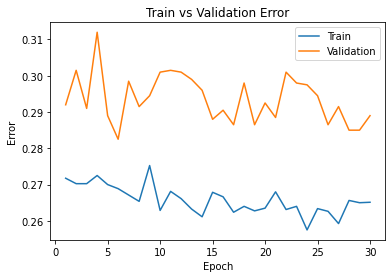

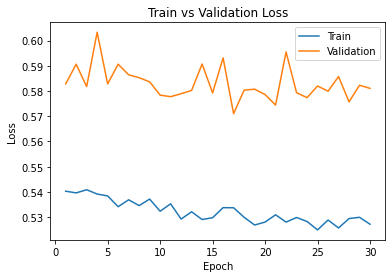

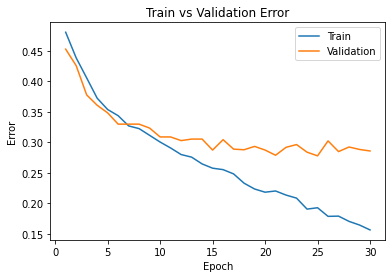

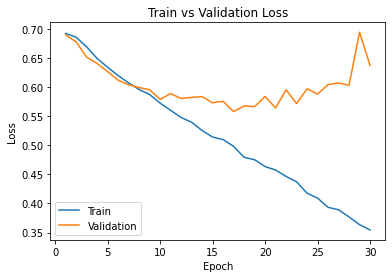

In [ ]:
model_path_small = get_model_name("small", 64, 0.01, 29)
model_path_large = get_model_name("large", 64, 0.01, 29)
plot_training_curve(model_path_small)
plot_training_curve(model_path_large)


### Part (f) - 5pt

Describe what you notice about the training curve.
How do the curves differ for `small_net` and `large_net`?
Identify any occurences of underfitting and overfitting.

In [ ]:
#Regarding the differences in performance shown by both models, we can see that the error and loss in the small network 
#diminish at a very slow pace, often oscillating around the same somewhat high values for both the training and validation cases; 
#even though the error and loss are lower for the training case and these values often decrease in magnitude, the slow pace and high 
#error/loss indicate underfitting to the training data.
#On the other hand, the large network shows way faster convergence to lower values for both error and loss. But
#we can see signs of overfitting and memorization of data as the epochs progress, since we start seeing an increase for
#the error and loss of the validation set as the same values for the training set rapidly continue decreasing as the epochs progress.

## Part 3. Optimization Parameters [12 pt]

For this section, we will work with `large_net` only.

### Part (a) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.001`.
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *lowering* the learning rate.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.50225, Train loss: 0.6945205240249633 |Validation err: 0.491, Validation loss: 0.6929903607815504
Epoch 2: Train err: 0.50225, Train loss: 0.6930275931358337 |Validation err: 0.491, Validation loss: 0.6924116816371679
Epoch 3: Train err: 0.487375, Train loss: 0.6922533187866211 |Validation err: 0.4765, Validation loss: 0.6920256800949574
Epoch 4: Train err: 0.448625, Train loss: 0.6916869764328003 |Validation err: 0.4515, Validation loss: 0.6913820113986731
Epoch 5: Train err: 0.44225, Train loss: 0.6910718812942505 |Validation err: 0.4415, Validation loss: 0.6910950168967247
Epoch 6: Train err: 0.44025, Train loss: 0.6903757758140564 |Validation err: 0.437, Validation loss: 0.6905075237154961
Epoch 7: Train err: 0.43825, Train loss: 0.6895534009933472 |Validation err: 0.434, Validation loss: 0.6896947920322418
Epoch 8: Train err: 0.439, Train loss: 0.6884737334251404 |Validation err: 0.43

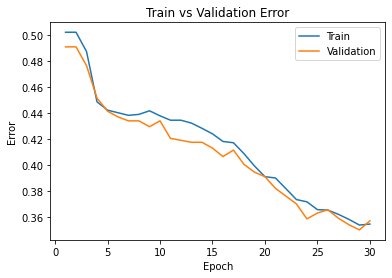

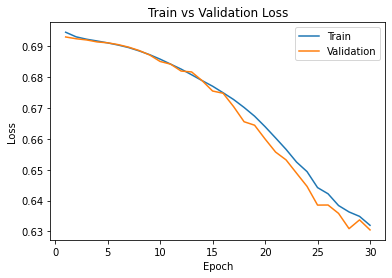

In [ ]:
# Note: When we re-construct the model, we start the training
# with *random weights*. If we omit this code, the values of
# the weights will still be the previously trained values.
large_net = LargeNet()
train_net(large_net,64,0.001,30)
model_path_large_new = get_model_name("large", 64, 0.001, 29)
plot_training_curve(model_path_large_new)
#Does the model take longer/shorter to train? 
#It took 112.51 seconds to train, which is close to .20 seconds more than when we set the learning rate to 0.01
#Describe the effect of lowering the learning rate.
#It takes longer to converge to lower values, but it does so without overfitting the model as in the previous scenario. The
#difference between the validation and training values for loss/error is much lower and does not vary much over time (which is good)
#This lowered learning rate should allow us to converge with more precision at the cost of future computing time and epochs, but so far
#the graphs show no signs of overfitting as previously seen (this is great actually). Less noisy plots. Also worth 
#mentioning that the error/loss for the validation set is generally lower than the training set's for the last epochs.

### Part (b) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.1`. 
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the learning rate.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.4295, Train loss: 0.67437779712677 |Validation err: 0.3595, Validation loss: 0.6350857093930244
Epoch 2: Train err: 0.36075, Train loss: 0.6411805458068848 |Validation err: 0.3535, Validation loss: 0.6361209936439991
Epoch 3: Train err: 0.365125, Train loss: 0.6321813461780548 |Validation err: 0.3385, Validation loss: 0.6056603882461786
Epoch 4: Train err: 0.352625, Train loss: 0.6233456182479858 |Validation err: 0.3575, Validation loss: 0.6362800188362598
Epoch 5: Train err: 0.34075, Train loss: 0.6108013873100281 |Validation err: 0.3305, Validation loss: 0.6064918786287308
Epoch 6: Train err: 0.323375, Train loss: 0.5921835997104645 |Validation err: 0.317, Validation loss: 0.5967769594863057
Epoch 7: Train err: 0.3145, Train loss: 0.5817317583560944 |Validation err: 0.3365, Validation loss: 0.6204487886279821
Epoch 8: Train err: 0.29825, Train loss: 0.5660300073623658 |Validation err: 0.

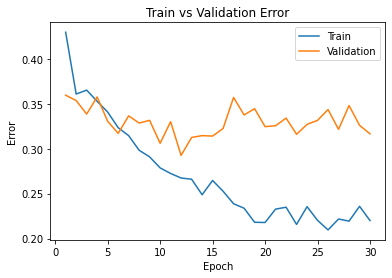

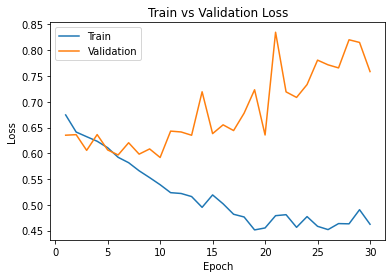

In [ ]:
# Note: When we re-construct the model, we start the training
# with *random weights*. If we omit this code, the values of
# the weights will still be the previously trained values.
large_net = LargeNet()
train_net(large_net,64,0.1,30)
model_path_large_new1 = get_model_name("large", 64, 0.1, 29)
plot_training_curve(model_path_large_new1)
#Does the model take longer/shorter to train? 
#It took 112.73 seconds, which is longer than in previous iterations with different learning rates
#Describe the effect of increasing the learning rate.
#It makes the model approach values faster due to the increased learning rate, but it also makes the model 
#overfit to the training data quite so, resulting in low training error/loss and ,after some point, increasing
#validation error/loss. It is alos worth noting that the training error appears to start a sort of plateau at the 
#end of the training, which  might indicate that the model might get stuck on those value without improving.
#Noisier plots

### Part (c) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=512`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the batch size.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.48175, Train loss: 0.6929379552602768 |Validation err: 0.478, Validation loss: 0.6926824003458023
Epoch 2: Train err: 0.457625, Train loss: 0.6924104019999504 |Validation err: 0.434, Validation loss: 0.6917425245046616
Epoch 3: Train err: 0.437, Train loss: 0.6916500590741634 |Validation err: 0.4265, Validation loss: 0.6909129917621613
Epoch 4: Train err: 0.433625, Train loss: 0.6908449940383434 |Validation err: 0.424, Validation loss: 0.6897870451211929
Epoch 5: Train err: 0.434, Train loss: 0.6896935552358627 |Validation err: 0.424, Validation loss: 0.6881355047225952
Epoch 6: Train err: 0.438, Train loss: 0.688353206962347 |Validation err: 0.4285, Validation loss: 0.686011865735054
Epoch 7: Train err: 0.439375, Train loss: 0.6866871677339077 |Validation err: 0.426, Validation loss: 0.6836968809366226
Epoch 8: Train err: 0.43525, Train loss: 0.6849770769476891 |Validation err: 0.4115, Va

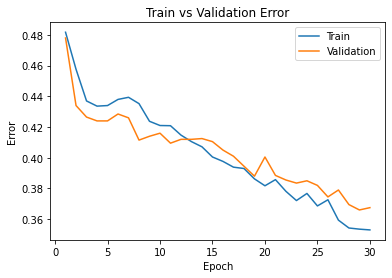

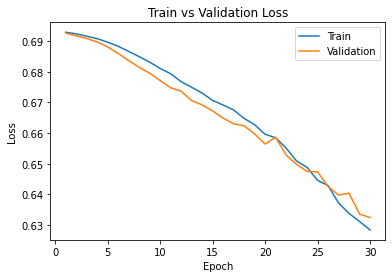

In [ ]:
# Note: When we re-construct the model, we start the training
# with *random weights*. If we omit this code, the values of
# the weights will still be the previously trained values.
large_net = LargeNet()
train_net(large_net,512,0.01,30)
model_path_large_new2 = get_model_name("large", 512, 0.01, 29)
plot_training_curve(model_path_large_new2)
#Does the model take longer/shorter to train? 
#It took 99.60 seconds to train, which is significantly shorter
#Describe the effect of increasing the batch size.
# Compared to the 1st case  (which had all the same parameters but had a batch size of 64), this iteration of the model
#performed much better and does not show the obvious signs of overfitting to the data the first model did. We see lower training times 
#as it examines more samples per batch.

### Part (d) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=16`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *decreasing* the batch size.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.43175, Train loss: 0.6774994022846222 |Validation err: 0.382, Validation loss: 0.6513170118331909
Epoch 2: Train err: 0.369, Train loss: 0.639639899969101 |Validation err: 0.3465, Validation loss: 0.6161113576889038
Epoch 3: Train err: 0.34375, Train loss: 0.6098222947120666 |Validation err: 0.3325, Validation loss: 0.6260210764408112
Epoch 4: Train err: 0.314375, Train loss: 0.5849691489338875 |Validation err: 0.34, Validation loss: 0.6044013917446136
Epoch 5: Train err: 0.301125, Train loss: 0.5689119303822517 |Validation err: 0.3125, Validation loss: 0.576918310880661
Epoch 6: Train err: 0.281, Train loss: 0.5452213581204415 |Validation err: 0.308, Validation loss: 0.5708447456359863
Epoch 7: Train err: 0.270875, Train loss: 0.5272981298565864 |Validation err: 0.307, Validation loss: 0.5854293291568756
Epoch 8: Train err: 0.259375, Train loss: 0.5070905526578426 |Validation err: 0.313, 

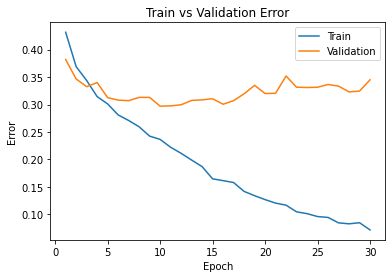

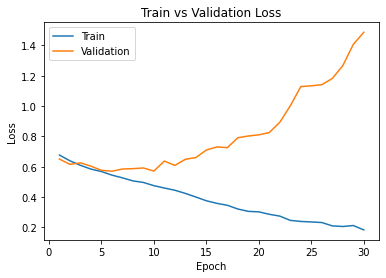

In [ ]:
# Note: When we re-construct the model, we start the training
# with *random weights*. If we omit this code, the values of
# the weights will still be the previously trained values.
large_net = LargeNet()
train_net(large_net,16,0.01,30)
model_path_large_new3 = get_model_name("large", 16, 0.01, 29)
plot_training_curve(model_path_large_new3)
#Does the model take longer/shorter to train? 
#It took 163.32 seconds, which is a lot more than any iteration of this kind so far
#Describe the effect of increasing the batch size.
# Increases training time significantly. There appears to be faster convergence to lower values of the
#training error/loss at the trade off of increasing validation error/loss as the epochs progress. This model
#showed the lowest training error, but also the highest increase in validation error, indicating heavy overfitting. The
#plots are not too noisy.

## Part 4. Hyperparameter Search [6 pt]

### Part (a) - 2pt

Based on the plots from above, choose another set of values for the hyperparameters (network, batch_size, learning_rate)
that you think would help you improve the validation accuracy. Justify your choice.

In [ ]:
#network chosen = large_net
#reasons = because I have toyed around with it more and because it shows the ability for the model to reduce error more efficiently 
#(compared to the small_net)
#batch_size chosen = 256 
#reasons = less overfitting, maybe better training time than batch size 512
#learning rate = 0.002 
#reasons = to get a better minimum error while keeping the stability of both errors/losses

### Part (b) - 1pt

Train the model with the hyperparameters you chose in part(a), and include the training curve.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.485875, Train loss: 0.6929944455623627 |Validation err: 0.492, Validation loss: 0.6929157003760338
Epoch 2: Train err: 0.474125, Train loss: 0.6927198935300112 |Validation err: 0.4645, Validation loss: 0.6924701780080795
Epoch 3: Train err: 0.460625, Train loss: 0.6924661844968796 |Validation err: 0.4485, Validation loss: 0.6921787336468697
Epoch 4: Train err: 0.449625, Train loss: 0.6921228487044573 |Validation err: 0.434, Validation loss: 0.6918384954333305
Epoch 5: Train err: 0.4415, Train loss: 0.691822836175561 |Validation err: 0.4285, Validation loss: 0.6913906186819077
Epoch 6: Train err: 0.434, Train loss: 0.691481489688158 |Validation err: 0.43, Validation loss: 0.6910017728805542
Epoch 7: Train err: 0.437375, Train loss: 0.6911117453128099 |Validation err: 0.4275, Validation loss: 0.690458819270134
Epoch 8: Train err: 0.43925, Train loss: 0.6907314658164978 |Validation err: 0.423

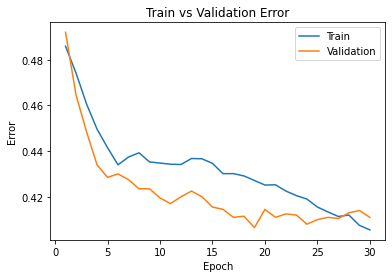

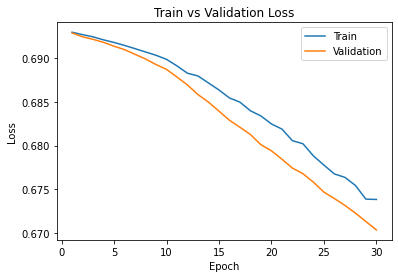

In [ ]:
large_net = LargeNet()
train_net(large_net,256,0.002,30)
model_path_large_bet1 = get_model_name("large", 256, 0.002, 29)
plot_training_curve(model_path_large_bet1)

### Part (c) - 2pt

Based on your result from Part(a), suggest another set of hyperparameter values to try. 
Justify your choice.

In [ ]:
#Same net, but switching the batch_size to 512 to keep the model stable and switching the learning rate to 0.02 
#to try to get lower error values

### Part (d) - 1pt

Train the model with the hyperparameters you chose in part(c), and include the training curve.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.476, Train loss: 0.692795880138874 |Validation err: 0.449, Validation loss: 0.6922057569026947
Epoch 2: Train err: 0.44975, Train loss: 0.691773921251297 |Validation err: 0.448, Validation loss: 0.690338060259819
Epoch 3: Train err: 0.438625, Train loss: 0.6900381222367287 |Validation err: 0.417, Validation loss: 0.6878800243139267
Epoch 4: Train err: 0.431875, Train loss: 0.6874969638884068 |Validation err: 0.4215, Validation loss: 0.6835321187973022
Epoch 5: Train err: 0.43375, Train loss: 0.6840997338294983 |Validation err: 0.409, Validation loss: 0.6794538497924805
Epoch 6: Train err: 0.4225, Train loss: 0.6805875524878502 |Validation err: 0.4135, Validation loss: 0.675282433629036
Epoch 7: Train err: 0.41425, Train loss: 0.6765112541615963 |Validation err: 0.4145, Validation loss: 0.6715693473815918
Epoch 8: Train err: 0.407, Train loss: 0.6727514304220676 |Validation err: 0.408, Vali

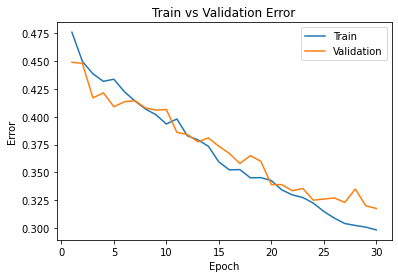

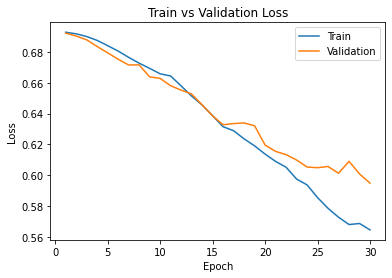

In [ ]:
large_net = LargeNet()
train_net(large_net,512,0.02,30)
model_path_large_bet2 = get_model_name("large", 512, 0.02, 29)
plot_training_curve(model_path_large_bet2)

## Part 4. Evaluating the Best Model [15 pt]


### Part (a) - 1pt

Choose the **best** model that you have so far. This means choosing the best model checkpoint,
including the choice of `small_net` vs `large_net`, the `batch_size`, `learning_rate`, 
**and the epoch number**.

Modify the code below to load your chosen set of weights to the model object `net`.

In [ ]:
net = LargeNet()
model_path = get_model_name(net.name, batch_size=512, learning_rate=0.02, epoch=29)
state = torch.load(model_path)
net.load_state_dict(state)

<All keys matched successfully>

### Part (b) - 2pt

Justify your choice of model from part (a).

In [ ]:
#It had the best validation error/stability and training time combo out of all my attempts

### Part (c) - 2pt

Using the code in Part 0, any code from lecture notes, or any code that you write,
compute and report the **test classification error** for your chosen model.

In [ ]:
# If you use the `evaluate` function provided in part 0, you will need to 
# set batch_size > 1
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"], 
    batch_size=64)
criterion = nn.BCEWithLogitsLoss()
test_err, test_loss = evaluate(net, test_loader, criterion)
print('Test Error: ', test_err,'\n')
print('Test Loss: ', test_loss,'\n')

Files already downloaded and verified
Files already downloaded and verified
Test Error:  0.313 

Test Loss:  0.5771453622728586 



### Part (d) - 3pt

How does the test classification error compare with the **validation error**?
Explain why you would expect the test error to be *higher* than the validation error.

In [ ]:
# I got a lowest Validation err: 0.3175, while I got a Test Error:  0.313. Normally one would expect the test error to be higher 
#due to the fact that we implicitly try to minimize the validation error during the training/validation phase, making the model fit better
#this validation subset of the data.

### Part (e) - 2pt

Why did we only use the test data set at the very end?
Why is it important that we use the test data as little as possible?

In [ ]:
#We use the test data as little as possible (ideally only once at the end of the model design) to try to avoid any biases
#our model might develop to certain data sets (to avoid fitting our model too much to our data that is supposed to help
#us test the effectiveness of our model)

### Part (f) - 5pt

How does the your best CNN model compare with an 2-layer ANN model (no convolutional layers) on classifying cat and dog images. You can use a 2-layer ANN architecture similar to what you used in Lab 1. You should explore different hyperparameter settings to determine how well you can do on the validation dataset. Once satisified with the performance, you may test it out on the test data.

Hint: The ANN in lab 1 was applied on greyscale images. The cat and dog images are colour (RGB) and so you will need to flatted and concatinate all three colour layers before feeding them into an ANN.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.495125, Train loss: 0.6947946287691593 |Validation err: 0.481, Validation loss: 0.6921192109584808
Epoch 2: Train err: 0.46175, Train loss: 0.6872302815318108 |Validation err: 0.433, Validation loss: 0.6855564266443253
Epoch 3: Train err: 0.42925, Train loss: 0.6817273311316967 |Validation err: 0.4225, Validation loss: 0.6815106719732285
Epoch 4: Train err: 0.419875, Train loss: 0.6772159598767757 |Validation err: 0.417, Validation loss: 0.6781929582357407
Epoch 5: Train err: 0.411125, Train loss: 0.6732605285942554 |Validation err: 0.4185, Validation loss: 0.675397664308548
Epoch 6: Train err: 0.405375, Train loss: 0.6703177355229855 |Validation err: 0.4145, Validation loss: 0.6727143228054047
Epoch 7: Train err: 0.3995, Train loss: 0.6676949113607407 |Validation err: 0.407, Validation loss: 0.6708437204360962
Epoch 8: Train err: 0.396, Train loss: 0.6654072254896164 |Validation err: 0.40

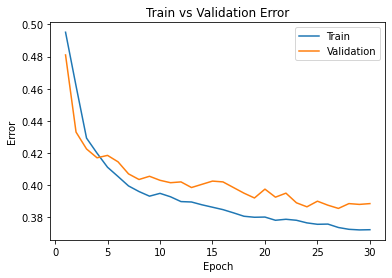

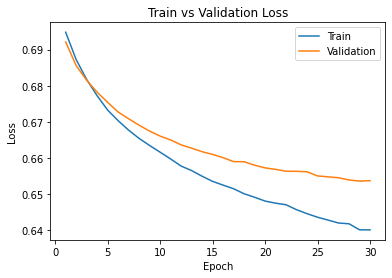

Files already downloaded and verified
Files already downloaded and verified
Test Error:  0.3655 

Test Loss:  0.6450779009610415 



In [ ]:
# define a 2-layer ANN, cat_brain
class cat_brain(nn.Module):
    def __init__(self):
        super(cat_brain, self).__init__()
        self.name = "cat"
        self.layer1 = nn.Linear(32 * 32 * 3, 32) #flatten the   RGB images
        self.layer2 = nn.Linear(32, 1)
    def forward(self, img):
        flattened = img.view(-1, 32 * 32 * 3)
        activation1 = self.layer1(flattened)
        activation1 = F.relu(activation1)
        activation2 = self.layer2(activation1)
        output = activation2.squeeze(1) #For compatibility purposes
        return output

cat = cat_brain()
train_net(cat,512,0.001,30)
model_path_cat = get_model_name("cat", 512, 0.001, 29)
plot_training_curve(model_path_cat)
    
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"], 
    batch_size=64)
criterion = nn.BCEWithLogitsLoss()
test_err, test_loss = evaluate(cat, test_loader, criterion)
print('Test Error: ', test_err,'\n')
print('Test Loss: ', test_loss,'\n')